In this notebook, I'm going to use 3 methods for extracting insights from ML models predictions:

1. Permutation Importance
1. Partial Plots
1. SHAP values


So...let's start by taking care of the basics:



# Importing and Exploring:

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/insurance/insurance.csv


In [2]:
dataset=pd.read_csv('../input/insurance/insurance.csv')

In [3]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
#I'm using get_dummies because there are more than 2 categories and assigning them numbers 1,2,3...
#can imply the feature's values have some sort of an order, which is not the case.
X=pd.get_dummies(dataset, prefix='loc', prefix_sep='_',columns=['region'])

In [6]:
#factorize goes down a column and assigns a number to whatever unique value it sees, so there's no
#telling which category gets which number, it depends on whichever category comes first.
X['sex'],_=X['sex'].factorize() 

# using below method, we get True/False values, which are treated the same way as binary values
X['smoker']=(X['smoker']=='yes')

In [7]:
X.head()

,age,sex,bmi,children,smoker,charges,loc_northeast,loc_northwest,loc_southeast,loc_southwest
0,19,0,27.900,0,True,16884.92400,0,0,0,1
1,18,1,33.770,1,False,1725.55230,0,0,1,0
2,28,1,33.000,3,False,4449.46200,0,0,1,0
3,33,1,22.705,0,False,21984.47061,0,1,0,0
4,32,1,28.880,0,False,3866.85520,0,1,0,0


In [8]:
y=X.pop('charges')

In [9]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=.2, random_state=0)

**Now Let's Import The Models and start extarcting info:**
> Here the focus is not on model building, so I'm not going to focus on hyperparameter tuning

# 1. Permutation Importance:

In [10]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(n_estimators=100, random_state=1).fit(train_X, train_y)

In [11]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(RFR, random_state=0).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = list(X.columns))

Weight,Feature
1.3894 ± 0.2195,smoker
0.2637 ± 0.0746,bmi
0.2027 ± 0.0436,age
0.0146 ± 0.0199,children
0.0074 ± 0.0083,loc_northeast
0.0028 ± 0.0030,loc_northwest
0.0015 ± 0.0045,sex
-0.0004 ± 0.0054,loc_southeast
-0.0016 ± 0.0023,loc_southwest


It shows that, features related to a person's health status and age have the highest importance for the model, which makes sense. and the regions and sex are not that important.

In [12]:
from xgboost import XGBRegressor
XGBR = XGBRegressor(n_estimators=100, random_state=1).fit(train_X,train_y)

In [13]:
perm1=PermutationImportance(XGBR,random_state=0).fit(val_X,val_y)
eli5.show_weights(perm1,feature_names=list(X.columns))

Weight,Feature
1.4376 ± 0.2214,smoker
0.2524 ± 0.0959,bmi
0.1764 ± 0.0290,age
0.0120 ± 0.0229,children
0.0047 ± 0.0094,loc_northeast
0.0013 ± 0.0037,sex
0.0010 ± 0.0058,loc_southeast
-0.0005 ± 0.0043,loc_northwest
-0.0011 ± 0.0054,loc_southwest


Same thing goes for this model too!
But in general, depending on the model, the feature importance order can change.

# 2. Partial Plots:
For Partial Dependence Plot we use the PDPBox library.

In [14]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
feature='bmi' #you can change it and see the plot for different features
charges = pdp.pdp_isolate(model=XGBR, dataset=val_X, model_features=list(X.columns), feature=feature)

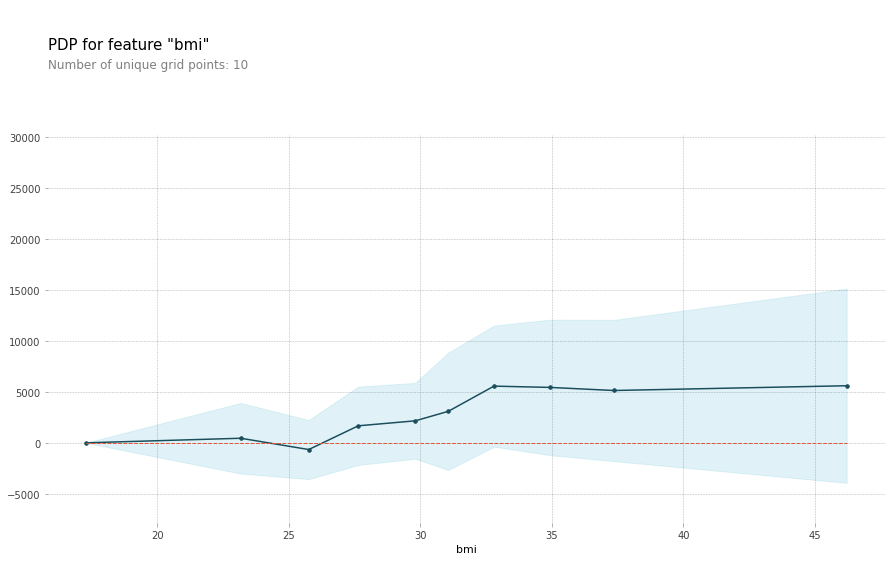

In [15]:
pdp.pdp_plot(charges, feature)
plt.show()

***Here's an interesting insight***

BMI ranges:

* Underweight: BMI is less than 18.5.
* Normal weight: BMI is 18.5 to 24.9.
* Overweight: BMI is 25 to 29.9.
* Obese: BMI is 30 or more.

BMI's at which the partial plot starts going up:

* almost 25
* almost 30

We can see the charges go higher at the thresholds of BMI range, so the bigger a person the higher their insurance charges.

**We can draw 2D partial plots to figure out interactions between features**

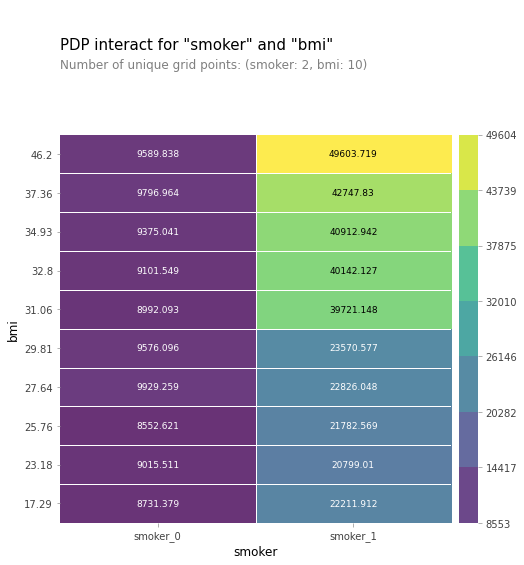

In [16]:
features_to_plot = ['smoker', 'bmi']
interact =  pdp.pdp_interact(model=RFR, dataset=val_X, model_features=list(X.columns), features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=features_to_plot, plot_type='grid')
plt.show()

If someone's a non-smoker, the charges are way lower, even if their bmi is not low!

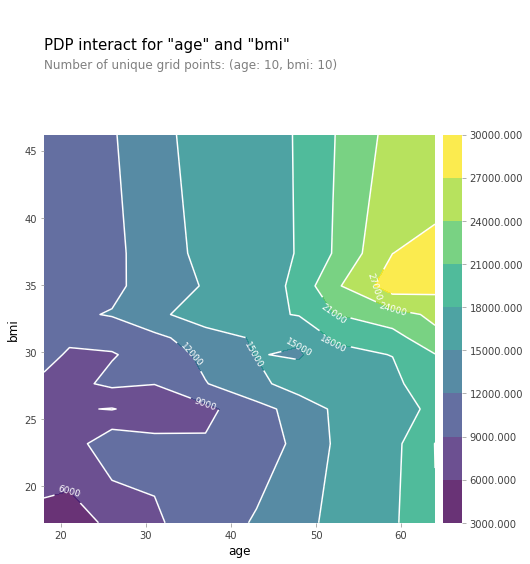

In [17]:
features_to_plot = ['age', 'bmi']
interact =  pdp.pdp_interact(model=XGBR, dataset=val_X, model_features=list(X.columns), features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=features_to_plot, plot_type='contour')
plt.show()

**NOTE** that in partial plots, the value of features change regardless of having those values in the dataset, it just shows how the target value changes when changing a feature within a range. the actual dataset might have just one value for that feature 90% of the time.

# 3. SHAP values:

In [18]:
import shap 

# Create object that can calculate shap values
explainer = shap.TreeExplainer(XGBR)

# Calculate Shap values
shap_values = explainer.shap_values(val_X)

**Summary plot**
> *The summary plot combines feature importance with feature effects.
> Each point on the summary plot is a Shapley value of an instance per feature.*

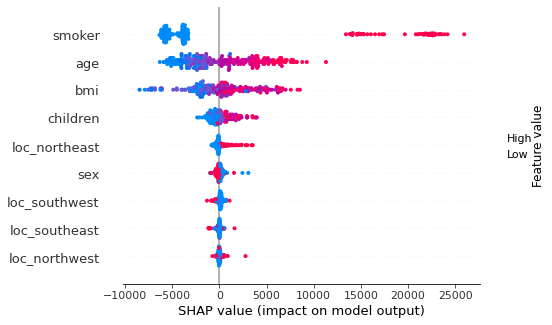

In [19]:
#in matplotlib V 3.5.1, there's this issue with feature value bar. don't really
#know how to solve it without downgrading to 3.4.1, but red is high and blue is low

shap.summary_plot(shap_values, val_X, feature_names=list(val_X.columns))

#Uncomment the code below to see the plot just for a portion of the dataset
#***************************
# shap.summary_plot(shap_values[0:5], val_X.iloc[0:5,:], feature_names=list(val_X.columns))
#***************************

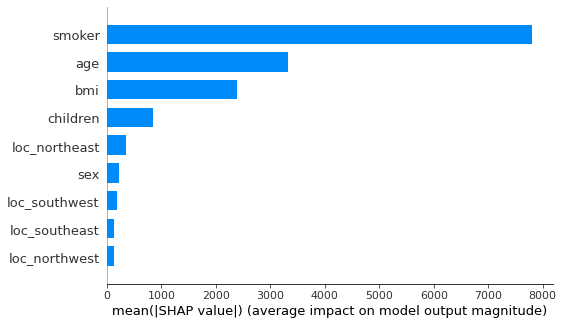

In [20]:
shap.summary_plot(shap_values, val_X, feature_names=list(val_X.columns),plot_type='bar')
#Note that these are the absolute form of mean SHAP values.
#so it just shows how important a feature is but not the direction of its effect on the prediction

*In the summary plot, we see first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots.*

**SHAP Dependence Plot**
> *The partial dependence plot (PDP or PD plot) shows the marginal effect -measure of the association between a change in a regressor, and a change in the response variable- that one or two features have on the predicted outcome of a machine learning model*
*[Here's a link to dependence plot document](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.dependence_plot.html), you can look up what each parameter does.*

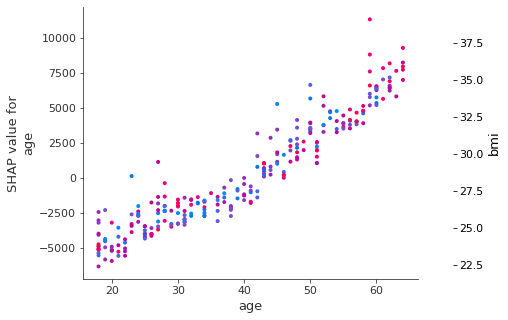

In [21]:
shap.dependence_plot('age', shap_values, features=val_X, interaction_index='bmi')

The colors show the bmi value, they don't really show a trend so it seems bmi and age don't have a strong interaction. Below is an obvious example to show interaction.

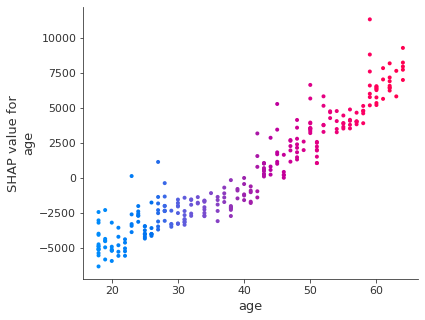

In [22]:
shap.dependence_plot('age', shap_values, features=val_X, interaction_index='age')

The change in the colors shows an obvious interaction between the two features ( both features are age so it's obvious the interaction is strong, I did this just for the purpose of demonstration)

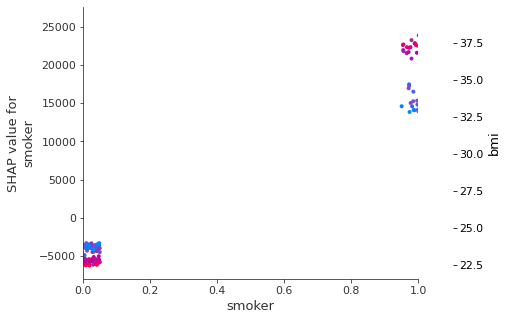

In [23]:
#x_jitter: Adds random jitter to feature values. May increase plot readability when feature is discrete.

#************************************

#interaction_index:
# The index of the feature used to color the plot. The name of a feature can also be passed as a string.
#If “auto” then shap.common.approximate_interactions is used to pick what seems to be the strongest
#interaction (note that to find true stongest interaction 
#you need to compute the SHAP interaction values).

#***********************************************

shap.dependence_plot('smoker', shap_values, features=val_X,x_jitter=.1, interaction_index='auto'
                     ,xmin=0,xmax=1)

Here, I didn't choose a second feature to investigate interaction, it's automatically chosen. So the bmi and smoker do have an interaction with eachother.

Here's what the plot is saying:

*  for smokers the gap between the SHAP values is much higher for people with different BMIs. so if someone's a smoker, then their BMI can become very important in determining the charge.

*  for non-smokers, different BMIs don't change the SHAP value that much, but it's interesting that non-smokers with higher BMIs decrease the SHAP value (hence the charge) a bit more than non-smokers with lower BMI.

**SHAP Force plot**
> This plot gives us the explainability of a single model prediction.

In [24]:
shap.initjs()
i = [0]
shap.force_plot(explainer.expected_value, shap_values[i], val_X.iloc[i,:], feature_names = list(val_X.columns))

Below we can see the predictions for a group of rows placed vertically (rotated of 90°) and side by side.

Hover the cursor over the horizontal numbers to see the most influencial features of each row.

In [25]:
i=range(0,3)
shap.force_plot(explainer.expected_value, shap_values[i], val_X.iloc[i,:], feature_names = list(val_X.columns),plot_cmap="DrDb")

**SHAP Decision plot**

The Decision Plot shows essentially the same information as the Force Plot. The grey vertical line is the base value and the red line indicates if each feature moved the output value to a higher or lower value than the average prediction.

This plot can be a little bit more clear and intuitive than the previous one, especially when there are many features to analyze. In the Force Plot, the information may look very condensed when the number of predictors is high.

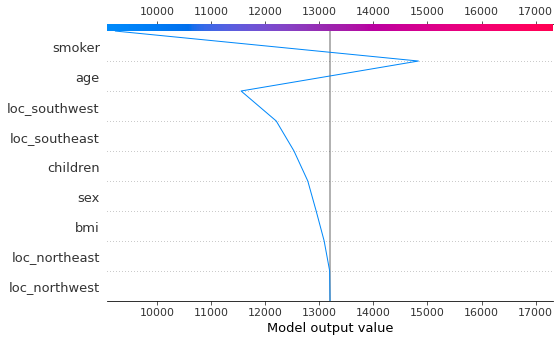

In [26]:
shap.decision_plot(explainer.expected_value, shap_values[0], feature_names = list(val_X.columns))

**How to interpret a decision plot**

Starting at the bottom of the plot, the prediction line shows how the SHAP values accumulate from the base value to arrive at the model’s final score at the top of the plot. Decision plots are a literal representation of SHAP values, making them easy to interpret.

**SHAP interaction plot**

In [27]:
shap_interaction = explainer.shap_interaction_values(val_X)

shap_interaction is a 3D array, it means that for every row, we have a 9 * 9, 2D array (because there are 9 features), showing the main effects and the interation effects, here the actual values are not important, because I just want to know which features' interaction is rather strong (hence the use heatmap)

In [28]:
#calculating the mean absoulte value for each pair of interaction in each 9*9 array
mean_abs_intr_df=pd.DataFrame(abs(shap_interaction).mean(0),columns=val_X.columns,index=val_X.columns)

<AxesSubplot:>

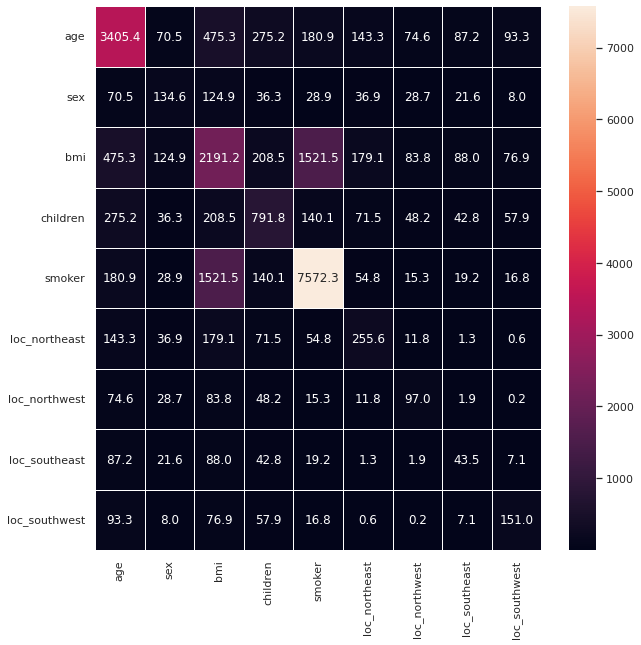

In [29]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1,)
sns.heatmap(mean_abs_intr_df,annot=True,fmt='.1f',linewidth=.5)

We can see that for off-diagonal values,smoker-bmi has lighter color so the interaction between these two is something to consider.

We can also use a summary plot to see the interactions!
> Here the SHAP values for the main effects are given on the diagonals and the off-diagonals give the interaction effects. The colours are given by the feature value for the feature on the y-axis. More on interaction plot [here](https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a#:~:text=SHAP%20values%20are%20used%20to,their%20main%20and%20interaction%20effects)


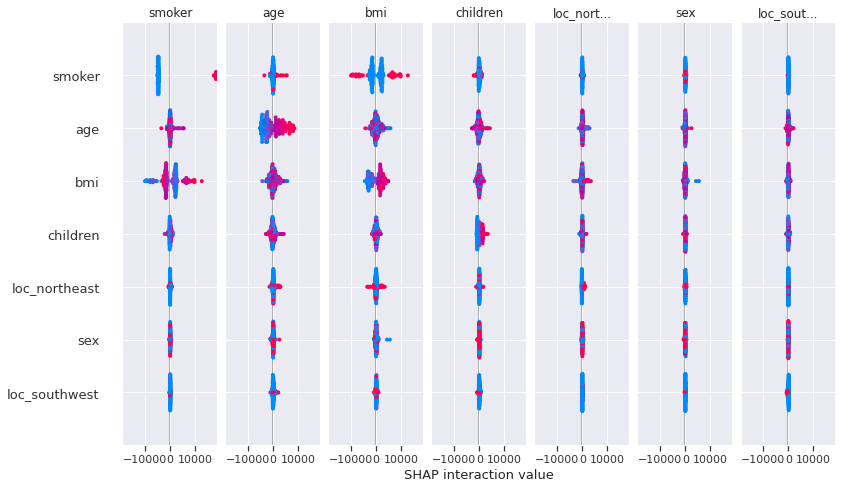

In [30]:
shap.summary_plot(shap_interaction,features=val_X)

***This was a simple dataset, but these tools can definitly help significantly when it comes to bigger and more complicated datasets!***

# References:

[This website](http://https://towardsdatascience.com/explainable-ai-xai-with-shap-regression-problem-b2d63fdca670) 

[Kaggle's ML explainability course](https://www.kaggle.com/learn/machine-learning-explainability)

BTW: If you know how to make the color bar for shap plots appear, please comment and let me know!